In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay

In [36]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [38]:
# Load datasets
data_dir = "D:/MLUP Proejct/Alzheimer_s Dataset"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [39]:
# Load pre-trained ResNet18 and modify the final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes
model = model.to(device)

c:\Users\haric\miniconda3\envs\pymlup\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haric\miniconda3\envs\pymlup\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [41]:
# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=20):
    model.train()
    best_accuracy = 0.0
    train_loss = []
    train_acc = []
    train_precision = []

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        true_positives = 0
        predicted_positives = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            true_positives += ((predicted == labels) & (predicted == 1)).sum().item()
            predicted_positives += (predicted == 1).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        epoch_precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
        
        scheduler.step(epoch_loss)
        
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        train_precision.append(epoch_precision)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Precision: {epoch_precision:.2f}%, Time: {time.time()-start_time:.2f}s")
        
        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

    torch.save(model.state_dict(), 'final_model.pth')
    print("Training Complete. Best Accuracy: {:.2f}%".format(best_accuracy))
    plot_training_curves(train_loss, train_acc, train_precision)

In [42]:
# Evaluate model with precision and confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            true_positives += ((predicted == labels) & (predicted == 1)).sum().item()
            predicted_positives += (predicted == 1).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Precision: {precision:.2f}%")
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds)
    # Plot precision-recall curve
    plot_precision_recall_curve(all_labels, all_preds)

In [43]:
# Plot training loss, accuracy, and precision
def plot_training_curves(train_loss, train_acc, train_precision):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'r-', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy vs. Epochs")
    plt.legend()

    # Precision Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_precision, 'g-', label="Training Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision (%)")
    plt.title("Training Precision vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [44]:
# Plot confusion matrix
def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mild", "Moderate", "Non", "VeryMild"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [45]:
# Plot precision-recall curve (simplified for multiclass)
def plot_precision_recall_curve(labels, preds):
    # Convert to binary for simplicity (e.g., class 1 vs rest)
    labels_bin = [1 if x == 1 else 0 for x in labels]
    preds_bin = [1 if x == 1 else 0 for x in preds]
    precision, recall, _ = precision_recall_curve(labels_bin, preds_bin)
    
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Class 1 vs Rest)")
    plt.grid()
    plt.show()

Epoch [1/20], Loss: 0.9316, Accuracy: 57.90%, Precision: 0.97%, Time: 55.66s
Epoch [2/20], Loss: 0.6791, Accuracy: 71.02%, Precision: 80.00%, Time: 53.46s
Epoch [3/20], Loss: 0.5301, Accuracy: 78.58%, Precision: 92.86%, Time: 51.69s
Epoch [4/20], Loss: 0.4073, Accuracy: 84.38%, Precision: 100.00%, Time: 51.45s
Epoch [5/20], Loss: 0.3157, Accuracy: 87.99%, Precision: 97.96%, Time: 51.96s
Epoch [6/20], Loss: 0.2485, Accuracy: 90.31%, Precision: 92.00%, Time: 51.45s
Epoch [7/20], Loss: 0.2048, Accuracy: 92.60%, Precision: 92.45%, Time: 54.18s
Epoch [8/20], Loss: 0.1539, Accuracy: 94.45%, Precision: 98.00%, Time: 53.68s
Epoch [9/20], Loss: 0.1505, Accuracy: 94.43%, Precision: 98.04%, Time: 53.41s
Epoch [10/20], Loss: 0.1291, Accuracy: 95.20%, Precision: 96.23%, Time: 50.92s
Epoch [11/20], Loss: 0.1148, Accuracy: 96.19%, Precision: 94.34%, Time: 52.92s
Epoch [12/20], Loss: 0.0981, Accuracy: 96.76%, Precision: 100.00%, Time: 52.98s
Epoch [13/20], Loss: 0.1070, Accuracy: 96.47%, Precision: 98

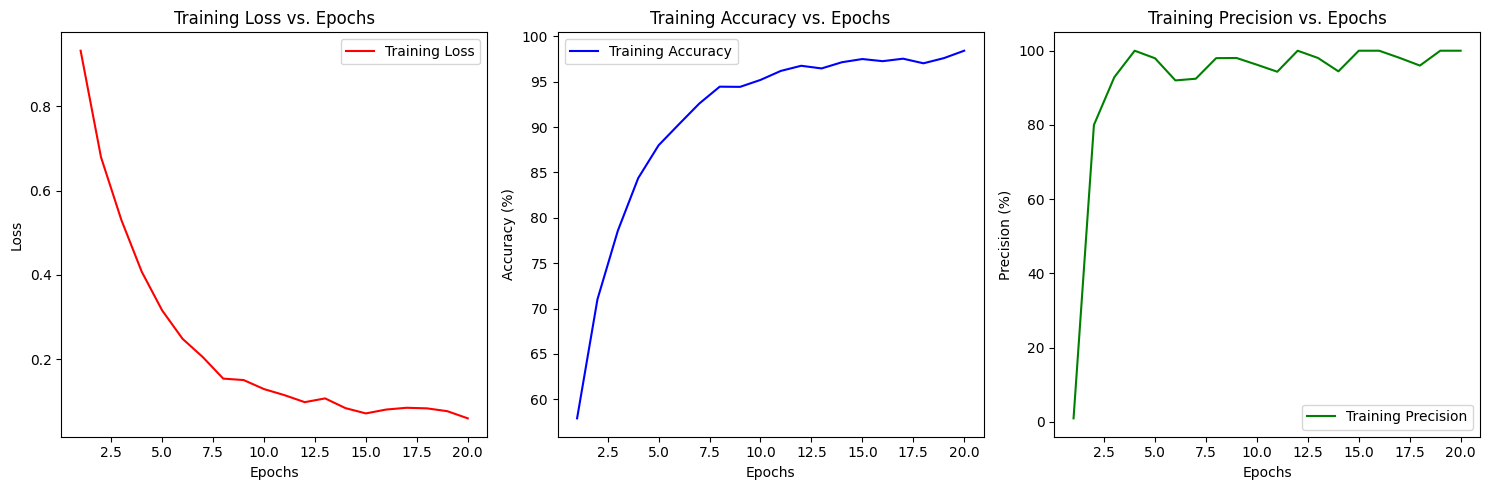

Test Accuracy: 80.30%
Test Precision: 70.59%


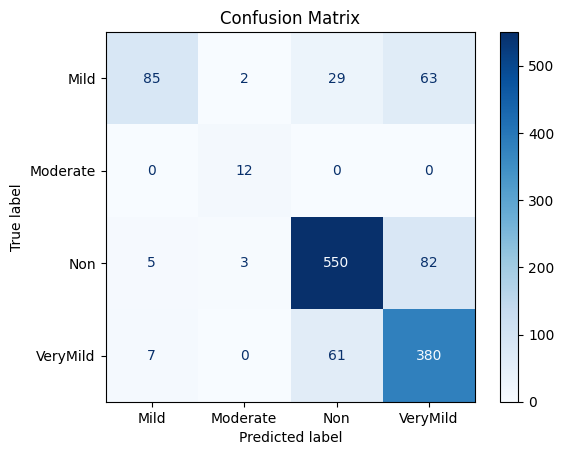

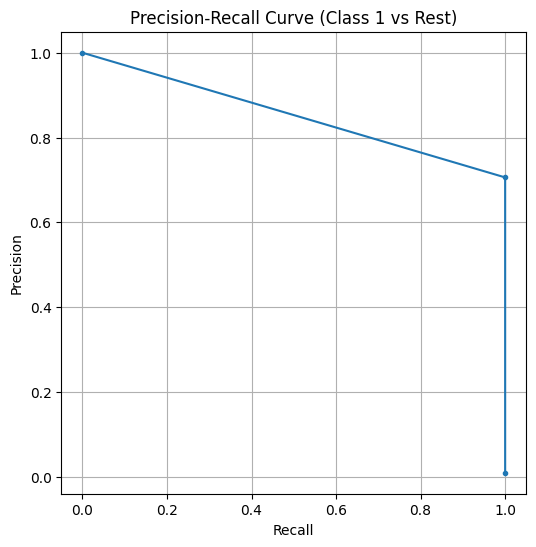

In [46]:
# Train and evaluate
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=20)
evaluate_model(model, test_loader)